In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6280 - acc: 0.1472
Epoch 00001: val_loss improved from inf to 2.42892, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/001-2.4289.hdf5
36805/36805 [==============================] - 30s 824us/sample - loss: 2.6279 - acc: 0.1473 - val_loss: 2.4289 - val_acc: 0.2541
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3702 - acc: 0.2209
Epoch 00002: val_loss improved from 2.42892 to 2.15127, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/002-2.1513.hdf5
36805/36805 [==============================] - 29s 777us/sample - loss: 2.3701 - acc: 0.2209 - val_loss: 2.1513 - val_acc: 0.3170
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 1.3716 - acc: 0.5466
Epoch 00021: val_loss improved from 1.09514 to 1.07950, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/021-1.0795.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 1.3716 - acc: 0.5466 - val_loss: 1.0795 - val_acc: 0.6622
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3497 - acc: 0.5534
Epoch 00022: val_loss improved from 1.07950 to 1.06688, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/022-1.0669.hdf5
36805/36805 [==============================] - 29s 776us/sample - loss: 1.3497 - acc: 0.5534 - val_loss: 1.0669 - val_acc: 0.6655
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3367 - acc: 0.5575
Epoch 00023: val_loss improved from 1.06688 to 1.04320, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/023-1.0432.hdf5
36805/

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1398 - acc: 0.6308
Epoch 00044: val_loss improved from 0.85629 to 0.84679, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/044-0.8468.hdf5
36805/36805 [==============================] - 28s 773us/sample - loss: 1.1397 - acc: 0.6308 - val_loss: 0.8468 - val_acc: 0.7412
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1330 - acc: 0.6318
Epoch 00045: val_loss did not improve from 0.84679
36805/36805 [==============================] - 29s 777us/sample - loss: 1.1331 - acc: 0.6318 - val_loss: 0.8528 - val_acc: 0.7363
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1328 - acc: 0.6331
Epoch 00046: val_loss improved from 0.84679 to 0.84434, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/046-0.8443.hdf5
36805/36805 [==============================] - 29s 777us/sample - loss: 1.1327 - acc: 0.6331 -

36800/36805 [============================>.] - ETA: 0s - loss: 1.0439 - acc: 0.6639
Epoch 00068: val_loss improved from 0.76501 to 0.76297, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/068-0.7630.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 1.0440 - acc: 0.6639 - val_loss: 0.7630 - val_acc: 0.7650
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0407 - acc: 0.6673
Epoch 00069: val_loss did not improve from 0.76297
36805/36805 [==============================] - 28s 772us/sample - loss: 1.0408 - acc: 0.6672 - val_loss: 0.7672 - val_acc: 0.7659
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0415 - acc: 0.6645
Epoch 00070: val_loss improved from 0.76297 to 0.76230, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/070-0.7623.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 1.0414 - acc: 0.6646 - val_loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.9919 - acc: 0.6809
Epoch 00094: val_loss did not improve from 0.71380
36805/36805 [==============================] - 29s 776us/sample - loss: 0.9918 - acc: 0.6809 - val_loss: 0.7146 - val_acc: 0.7857
Epoch 95/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9867 - acc: 0.6832
Epoch 00095: val_loss improved from 0.71380 to 0.70830, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/095-0.7083.hdf5
36805/36805 [==============================] - 29s 777us/sample - loss: 0.9868 - acc: 0.6832 - val_loss: 0.7083 - val_acc: 0.7824
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9901 - acc: 0.6824
Epoch 00096: val_loss improved from 0.70830 to 0.70179, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/096-0.7018.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 0.9902 - acc: 0.6824 - val_loss: 0.

Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9467 - acc: 0.6939
Epoch 00121: val_loss did not improve from 0.67873
36805/36805 [==============================] - 29s 777us/sample - loss: 0.9466 - acc: 0.6940 - val_loss: 0.6801 - val_acc: 0.7957
Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9514 - acc: 0.6969
Epoch 00122: val_loss did not improve from 0.67873
36805/36805 [==============================] - 29s 777us/sample - loss: 0.9514 - acc: 0.6969 - val_loss: 0.6857 - val_acc: 0.7932
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9478 - acc: 0.6978
Epoch 00123: val_loss did not improve from 0.67873
36805/36805 [==============================] - 29s 776us/sample - loss: 0.9478 - acc: 0.6978 - val_loss: 0.6789 - val_acc: 0.7959
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9475 - acc: 0.6938
Epoch 00124: val_loss improved from 0.67873 to 0.67510, saving mo

Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9204 - acc: 0.7038
Epoch 00148: val_loss did not improve from 0.65380
36805/36805 [==============================] - 29s 776us/sample - loss: 0.9205 - acc: 0.7037 - val_loss: 0.6567 - val_acc: 0.7997
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9165 - acc: 0.7057
Epoch 00149: val_loss did not improve from 0.65380
36805/36805 [==============================] - 29s 776us/sample - loss: 0.9166 - acc: 0.7057 - val_loss: 0.6606 - val_acc: 0.8022
Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9143 - acc: 0.7079
Epoch 00150: val_loss did not improve from 0.65380
36805/36805 [==============================] - 29s 776us/sample - loss: 0.9144 - acc: 0.7079 - val_loss: 0.6609 - val_acc: 0.8015
Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9098 - acc: 0.7095
Epoch 00151: val_loss did not improve from 0.65380
36805/36805 [=

Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8940 - acc: 0.7134
Epoch 00176: val_loss did not improve from 0.63359
36805/36805 [==============================] - 29s 774us/sample - loss: 0.8939 - acc: 0.7134 - val_loss: 0.6498 - val_acc: 0.8043
Epoch 177/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8906 - acc: 0.7129
Epoch 00177: val_loss did not improve from 0.63359
36805/36805 [==============================] - 29s 777us/sample - loss: 0.8906 - acc: 0.7128 - val_loss: 0.6450 - val_acc: 0.8036
Epoch 178/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8835 - acc: 0.7166
Epoch 00178: val_loss did not improve from 0.63359
36805/36805 [==============================] - 28s 773us/sample - loss: 0.8836 - acc: 0.7166 - val_loss: 0.6376 - val_acc: 0.8104
Epoch 179/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8921 - acc: 0.7156
Epoch 00179: val_loss did not improve from 0.63359
36805/36805 [=

Epoch 204/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8632 - acc: 0.7241
Epoch 00204: val_loss did not improve from 0.62316
36805/36805 [==============================] - 29s 778us/sample - loss: 0.8632 - acc: 0.7241 - val_loss: 0.6283 - val_acc: 0.8125
Epoch 205/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8641 - acc: 0.7254
Epoch 00205: val_loss did not improve from 0.62316
36805/36805 [==============================] - 29s 778us/sample - loss: 0.8641 - acc: 0.7254 - val_loss: 0.6242 - val_acc: 0.8134
Epoch 206/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8665 - acc: 0.7216
Epoch 00206: val_loss did not improve from 0.62316
36805/36805 [==============================] - 29s 776us/sample - loss: 0.8664 - acc: 0.7216 - val_loss: 0.6314 - val_acc: 0.8111
Epoch 207/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8646 - acc: 0.7222
Epoch 00207: val_loss did not improve from 0.62316
36805/36805 [=

Epoch 232/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8532 - acc: 0.7248
Epoch 00232: val_loss did not improve from 0.60918
36805/36805 [==============================] - 29s 776us/sample - loss: 0.8532 - acc: 0.7248 - val_loss: 0.6160 - val_acc: 0.8160
Epoch 233/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8523 - acc: 0.7250
Epoch 00233: val_loss did not improve from 0.60918
36805/36805 [==============================] - 29s 775us/sample - loss: 0.8523 - acc: 0.7250 - val_loss: 0.6187 - val_acc: 0.8132
Epoch 234/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8515 - acc: 0.7255
Epoch 00234: val_loss did not improve from 0.60918
36805/36805 [==============================] - 29s 783us/sample - loss: 0.8515 - acc: 0.7256 - val_loss: 0.6210 - val_acc: 0.8157
Epoch 235/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8480 - acc: 0.7280
Epoch 00235: val_loss did not improve from 0.60918
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.8286 - acc: 0.7313
Epoch 00260: val_loss did not improve from 0.60237
36805/36805 [==============================] - 28s 772us/sample - loss: 0.8284 - acc: 0.7314 - val_loss: 0.6103 - val_acc: 0.8088
Epoch 261/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8334 - acc: 0.7321
Epoch 00261: val_loss improved from 0.60237 to 0.59957, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_3_conv_checkpoint/261-0.5996.hdf5
36805/36805 [==============================] - 29s 776us/sample - loss: 0.8333 - acc: 0.7321 - val_loss: 0.5996 - val_acc: 0.8197
Epoch 262/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8325 - acc: 0.7306
Epoch 00262: val_loss did not improve from 0.59957
36805/36805 [==============================] - 28s 773us/sample - loss: 0.8326 - acc: 0.7305 - val_loss: 0.6048 - val_acc: 0.8190
Epoch 263/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8127 - acc: 0.7382
Epoch 00289: val_loss did not improve from 0.59583
36805/36805 [==============================] - 28s 772us/sample - loss: 0.8129 - acc: 0.7381 - val_loss: 0.6089 - val_acc: 0.8176
Epoch 290/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8199 - acc: 0.7368
Epoch 00290: val_loss did not improve from 0.59583
36805/36805 [==============================] - 28s 772us/sample - loss: 0.8199 - acc: 0.7368 - val_loss: 0.6041 - val_acc: 0.8183
Epoch 291/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8146 - acc: 0.7358
Epoch 00291: val_loss did not improve from 0.59583
36805/36805 [==============================] - 28s 772us/sample - loss: 0.8146 - acc: 0.7358 - val_loss: 0.6007 - val_acc: 0.8195
Epoch 292/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8163 - acc: 0.7371
Epoch 00292: val_loss did not improve from 0.59583
36805/36805 [=

Epoch 317/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8026 - acc: 0.7395
Epoch 00317: val_loss did not improve from 0.58685
36805/36805 [==============================] - 28s 773us/sample - loss: 0.8026 - acc: 0.7395 - val_loss: 0.5892 - val_acc: 0.8244
Epoch 318/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8012 - acc: 0.7386
Epoch 00318: val_loss did not improve from 0.58685
36805/36805 [==============================] - 28s 774us/sample - loss: 0.8012 - acc: 0.7386 - val_loss: 0.5937 - val_acc: 0.8223
Epoch 319/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8058 - acc: 0.7400
Epoch 00319: val_loss did not improve from 0.58685
36805/36805 [==============================] - 28s 773us/sample - loss: 0.8056 - acc: 0.7400 - val_loss: 0.5908 - val_acc: 0.8260
Epoch 320/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8039 - acc: 0.7439
Epoch 00320: val_loss did not improve from 0.58685
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7888 - acc: 0.7450
Epoch 00345: val_loss did not improve from 0.58148
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7887 - acc: 0.7450 - val_loss: 0.5980 - val_acc: 0.8174
Epoch 346/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7943 - acc: 0.7437
Epoch 00346: val_loss did not improve from 0.58148
36805/36805 [==============================] - 28s 770us/sample - loss: 0.7940 - acc: 0.7438 - val_loss: 0.5996 - val_acc: 0.8211
Epoch 347/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7868 - acc: 0.7436
Epoch 00347: val_loss did not improve from 0.58148
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7870 - acc: 0.7435 - val_loss: 0.5889 - val_acc: 0.8248
Epoch 348/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7973 - acc: 0.7424
Epoch 00348: val_loss did not improve from 0.58148
36805/36805 [===============

Epoch 375/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7740 - acc: 0.7483
Epoch 00375: val_loss did not improve from 0.58148
36805/36805 [==============================] - 29s 780us/sample - loss: 0.7740 - acc: 0.7482 - val_loss: 0.5818 - val_acc: 0.8279
Epoch 376/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7806 - acc: 0.7476
Epoch 00376: val_loss did not improve from 0.58148
36805/36805 [==============================] - 29s 780us/sample - loss: 0.7805 - acc: 0.7476 - val_loss: 0.5866 - val_acc: 0.8267
Epoch 377/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7759 - acc: 0.7482
Epoch 00377: val_loss did not improve from 0.58148
36805/36805 [==============================] - 28s 773us/sample - loss: 0.7759 - acc: 0.7482 - val_loss: 0.5865 - val_acc: 0.8237
Epoch 378/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7796 - acc: 0.7471
Epoch 00378: val_loss did not improve from 0.58148
36805/36805 [=

Epoch 403/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7772 - acc: 0.7514
Epoch 00403: val_loss did not improve from 0.57848
36805/36805 [==============================] - 28s 773us/sample - loss: 0.7772 - acc: 0.7514 - val_loss: 0.5879 - val_acc: 0.8255
Epoch 404/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7734 - acc: 0.7488
Epoch 00404: val_loss did not improve from 0.57848
36805/36805 [==============================] - 28s 770us/sample - loss: 0.7733 - acc: 0.7488 - val_loss: 0.5978 - val_acc: 0.8237
Epoch 405/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7736 - acc: 0.7480
Epoch 00405: val_loss did not improve from 0.57848
36805/36805 [==============================] - 28s 771us/sample - loss: 0.7736 - acc: 0.7480 - val_loss: 0.5790 - val_acc: 0.8255
Epoch 406/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7714 - acc: 0.7483
Epoch 00406: val_loss did not improve from 0.57848
36805/36805 [=

Epoch 432/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7559 - acc: 0.7543
Epoch 00432: val_loss did not improve from 0.57397
36805/36805 [==============================] - 28s 773us/sample - loss: 0.7558 - acc: 0.7544 - val_loss: 0.5843 - val_acc: 0.8241
Epoch 433/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7598 - acc: 0.7531
Epoch 00433: val_loss did not improve from 0.57397
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7598 - acc: 0.7531 - val_loss: 0.5808 - val_acc: 0.8295
Epoch 434/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7659 - acc: 0.7514
Epoch 00434: val_loss did not improve from 0.57397
36805/36805 [==============================] - 29s 775us/sample - loss: 0.7661 - acc: 0.7514 - val_loss: 0.5994 - val_acc: 0.8213
Epoch 435/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7638 - acc: 0.7522
Epoch 00435: val_loss did not improve from 0.57397
36805/36805 [=

Epoch 461/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7461 - acc: 0.7560
Epoch 00461: val_loss did not improve from 0.56922
36805/36805 [==============================] - 28s 774us/sample - loss: 0.7460 - acc: 0.7560 - val_loss: 0.5718 - val_acc: 0.8316
Epoch 462/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7496 - acc: 0.7563
Epoch 00462: val_loss did not improve from 0.56922
36805/36805 [==============================] - 28s 769us/sample - loss: 0.7497 - acc: 0.7563 - val_loss: 0.5809 - val_acc: 0.8302
Epoch 463/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7575 - acc: 0.7519
Epoch 00463: val_loss did not improve from 0.56922
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7573 - acc: 0.7521 - val_loss: 0.5794 - val_acc: 0.8297
Epoch 464/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7533 - acc: 0.7548
Epoch 00464: val_loss did not improve from 0.56922
36805/36805 [=

Epoch 491/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7344 - acc: 0.7597
Epoch 00491: val_loss did not improve from 0.56922
36805/36805 [==============================] - 28s 773us/sample - loss: 0.7344 - acc: 0.7597 - val_loss: 0.5742 - val_acc: 0.8297
Epoch 492/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7369 - acc: 0.7600
Epoch 00492: val_loss did not improve from 0.56922
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7369 - acc: 0.7600 - val_loss: 0.5714 - val_acc: 0.8307
Epoch 493/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7395 - acc: 0.7619
Epoch 00493: val_loss did not improve from 0.56922
36805/36805 [==============================] - 29s 779us/sample - loss: 0.7395 - acc: 0.7620 - val_loss: 0.5777 - val_acc: 0.8297
Epoch 494/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7393 - acc: 0.7591
Epoch 00494: val_loss did not improve from 0.56922
36805/36805 [=

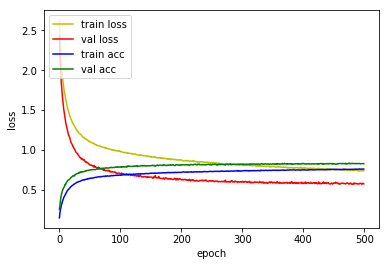

4815/4815 [==============================] - 2s 370us/sample - loss: 0.6528 - acc: 0.8073
Loss: 0.6527872024047907 Accuracy: 0.807269

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5651 - acc: 0.1542
Epoch 00001: val_loss improved from inf to 2.23552, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/001-2.2355.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 2.5645 - acc: 0.1544 - val_loss: 2.2355 - val_acc: 0.3222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2166 - acc: 0.2514
Epoch 00002: val_loss improved from 2.23552 to 1.95257, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/002-1.9526.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 2.2165 - acc: 0.2515 - val_loss: 1.9526 - val_acc: 0.3997
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.9974 - acc: 0.6818
Epoch 00022: val_loss improved from 0.73226 to 0.71731, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/022-0.7173.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9974 - acc: 0.6818 - val_loss: 0.7173 - val_acc: 0.7859
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9822 - acc: 0.6863
Epoch 00023: val_loss improved from 0.71731 to 0.69532, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/023-0.6953.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9823 - acc: 0.6862 - val_loss: 0.6953 - val_acc: 0.7934
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9687 - acc: 0.6905
Epoch 00024: val_loss improved from 0.69532 to 0.68837, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/024-0.6884.hdf5
36805/

Epoch 45/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7720 - acc: 0.7557
Epoch 00045: val_loss improved from 0.51416 to 0.50593, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/045-0.5059.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 0.7721 - acc: 0.7557 - val_loss: 0.5059 - val_acc: 0.8516
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7600 - acc: 0.7617
Epoch 00046: val_loss did not improve from 0.50593
36805/36805 [==============================] - 29s 797us/sample - loss: 0.7599 - acc: 0.7617 - val_loss: 0.5088 - val_acc: 0.8484
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7564 - acc: 0.7665
Epoch 00047: val_loss improved from 0.50593 to 0.48981, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/047-0.4898.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 0.7563 - acc: 0.7665 -

Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6785 - acc: 0.7863
Epoch 00070: val_loss did not improve from 0.42995
36805/36805 [==============================] - 29s 797us/sample - loss: 0.6785 - acc: 0.7863 - val_loss: 0.4395 - val_acc: 0.8682
Epoch 71/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6743 - acc: 0.7883
Epoch 00071: val_loss did not improve from 0.42995
36805/36805 [==============================] - 29s 794us/sample - loss: 0.6745 - acc: 0.7881 - val_loss: 0.4386 - val_acc: 0.8724
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6652 - acc: 0.7913
Epoch 00072: val_loss improved from 0.42995 to 0.42925, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/072-0.4293.hdf5
36805/36805 [==============================] - 29s 794us/sample - loss: 0.6654 - acc: 0.7912 - val_loss: 0.4293 - val_acc: 0.8737
Epoch 73/500
36736/36805 [============================>.] - ETA: 

Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6156 - acc: 0.8087
Epoch 00096: val_loss improved from 0.39525 to 0.39482, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/096-0.3948.hdf5
36805/36805 [==============================] - 29s 790us/sample - loss: 0.6156 - acc: 0.8087 - val_loss: 0.3948 - val_acc: 0.8849
Epoch 97/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6128 - acc: 0.8081
Epoch 00097: val_loss did not improve from 0.39482
36805/36805 [==============================] - 29s 796us/sample - loss: 0.6131 - acc: 0.8080 - val_loss: 0.4047 - val_acc: 0.8817
Epoch 98/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6044 - acc: 0.8095
Epoch 00098: val_loss did not improve from 0.39482
36805/36805 [==============================] - 29s 792us/sample - loss: 0.6049 - acc: 0.8093 - val_loss: 0.3952 - val_acc: 0.8842
Epoch 99/500
36800/36805 [============================>.] - ETA: 

Epoch 123/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5748 - acc: 0.8190
Epoch 00123: val_loss did not improve from 0.37224
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5748 - acc: 0.8189 - val_loss: 0.3945 - val_acc: 0.8833
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5726 - acc: 0.8200
Epoch 00124: val_loss did not improve from 0.37224
36805/36805 [==============================] - 29s 794us/sample - loss: 0.5726 - acc: 0.8200 - val_loss: 0.3885 - val_acc: 0.8873
Epoch 125/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5696 - acc: 0.8212
Epoch 00125: val_loss did not improve from 0.37224
36805/36805 [==============================] - 29s 798us/sample - loss: 0.5694 - acc: 0.8212 - val_loss: 0.3789 - val_acc: 0.8912
Epoch 126/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5691 - acc: 0.8206
Epoch 00126: val_loss did not improve from 0.37224
36805/36805 [=

Epoch 151/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5370 - acc: 0.8318
Epoch 00151: val_loss did not improve from 0.36024
36805/36805 [==============================] - 29s 798us/sample - loss: 0.5369 - acc: 0.8317 - val_loss: 0.3726 - val_acc: 0.8896
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.8309
Epoch 00152: val_loss did not improve from 0.36024
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5356 - acc: 0.8309 - val_loss: 0.3790 - val_acc: 0.8875
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5348 - acc: 0.8307
Epoch 00153: val_loss did not improve from 0.36024
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5350 - acc: 0.8306 - val_loss: 0.3771 - val_acc: 0.8884
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5397 - acc: 0.8312
Epoch 00154: val_loss did not improve from 0.36024
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.5063 - acc: 0.8398
Epoch 00180: val_loss did not improve from 0.35862
36805/36805 [==============================] - 29s 798us/sample - loss: 0.5065 - acc: 0.8398 - val_loss: 0.3598 - val_acc: 0.8961
Epoch 181/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5096 - acc: 0.8397
Epoch 00181: val_loss did not improve from 0.35862
36805/36805 [==============================] - 29s 790us/sample - loss: 0.5095 - acc: 0.8398 - val_loss: 0.3615 - val_acc: 0.8949
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5052 - acc: 0.8404
Epoch 00182: val_loss did not improve from 0.35862
36805/36805 [==============================] - 29s 789us/sample - loss: 0.5052 - acc: 0.8404 - val_loss: 0.3660 - val_acc: 0.8905
Epoch 183/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5103 - acc: 0.8362
Epoch 00183: val_loss did not improve from 0.35862
36805/36805 [===============

Epoch 209/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4859 - acc: 0.8443
Epoch 00209: val_loss did not improve from 0.35144
36805/36805 [==============================] - 29s 799us/sample - loss: 0.4859 - acc: 0.8443 - val_loss: 0.3544 - val_acc: 0.8921
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4883 - acc: 0.8435
Epoch 00210: val_loss did not improve from 0.35144
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4883 - acc: 0.8435 - val_loss: 0.3556 - val_acc: 0.8919
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4874 - acc: 0.8445
Epoch 00211: val_loss did not improve from 0.35144
36805/36805 [==============================] - 29s 801us/sample - loss: 0.4874 - acc: 0.8445 - val_loss: 0.3518 - val_acc: 0.8954
Epoch 212/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4800 - acc: 0.8463
Epoch 00212: val_loss did not improve from 0.35144
36805/36805 [=

Epoch 238/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4739 - acc: 0.8472
Epoch 00238: val_loss did not improve from 0.35022
36805/36805 [==============================] - 29s 798us/sample - loss: 0.4739 - acc: 0.8472 - val_loss: 0.3579 - val_acc: 0.8924
Epoch 239/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4627 - acc: 0.8513
Epoch 00239: val_loss did not improve from 0.35022
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4626 - acc: 0.8513 - val_loss: 0.3580 - val_acc: 0.8928
Epoch 240/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4640 - acc: 0.8516
Epoch 00240: val_loss did not improve from 0.35022
36805/36805 [==============================] - 29s 798us/sample - loss: 0.4639 - acc: 0.8515 - val_loss: 0.3553 - val_acc: 0.8940
Epoch 241/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4623 - acc: 0.8532
Epoch 00241: val_loss did not improve from 0.35022
36805/36805 [=

Epoch 268/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.8557
Epoch 00268: val_loss did not improve from 0.35022
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4468 - acc: 0.8556 - val_loss: 0.3520 - val_acc: 0.8947
Epoch 269/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4444 - acc: 0.8558
Epoch 00269: val_loss improved from 0.35022 to 0.34918, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_4_conv_checkpoint/269-0.3492.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 0.4442 - acc: 0.8559 - val_loss: 0.3492 - val_acc: 0.8984
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4451 - acc: 0.8563
Epoch 00270: val_loss did not improve from 0.34918
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4451 - acc: 0.8563 - val_loss: 0.3554 - val_acc: 0.8966
Epoch 271/500
36736/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.4325 - acc: 0.8590
Epoch 00297: val_loss did not improve from 0.34918
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4325 - acc: 0.8590 - val_loss: 0.3592 - val_acc: 0.8947
Epoch 298/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4416 - acc: 0.8579
Epoch 00298: val_loss did not improve from 0.34918
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4414 - acc: 0.8579 - val_loss: 0.3546 - val_acc: 0.8959
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4275 - acc: 0.8617
Epoch 00299: val_loss did not improve from 0.34918
36805/36805 [==============================] - 29s 797us/sample - loss: 0.4275 - acc: 0.8618 - val_loss: 0.3625 - val_acc: 0.8928
Epoch 300/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4326 - acc: 0.8605
Epoch 00300: val_loss did not improve from 0.34918
36805/36805 [===============

36736/36805 [============================>.] - ETA: 0s - loss: 0.4207 - acc: 0.8637
Epoch 00326: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4208 - acc: 0.8636 - val_loss: 0.3612 - val_acc: 0.8942
Epoch 327/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4202 - acc: 0.8638
Epoch 00327: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 788us/sample - loss: 0.4200 - acc: 0.8639 - val_loss: 0.3641 - val_acc: 0.8901
Epoch 328/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4175 - acc: 0.8661
Epoch 00328: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4175 - acc: 0.8661 - val_loss: 0.3609 - val_acc: 0.8924
Epoch 329/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4265 - acc: 0.8615
Epoch 00329: val_loss did not improve from 0.34916
36805/36805 [===============

Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.8704
Epoch 00356: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4040 - acc: 0.8704 - val_loss: 0.3760 - val_acc: 0.8870
Epoch 357/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4052 - acc: 0.8693
Epoch 00357: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4055 - acc: 0.8693 - val_loss: 0.3620 - val_acc: 0.8917
Epoch 358/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4113 - acc: 0.8674
Epoch 00358: val_loss did not improve from 0.34916
36805/36805 [==============================] - 29s 799us/sample - loss: 0.4114 - acc: 0.8673 - val_loss: 0.3626 - val_acc: 0.8915
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4108 - acc: 0.8674
Epoch 00359: val_loss did not improve from 0.34916
36805/36805 [=

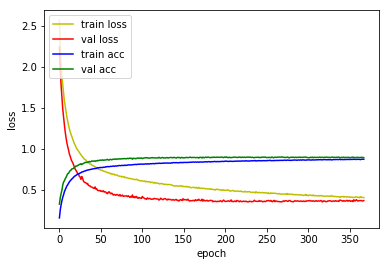

4815/4815 [==============================] - 2s 365us/sample - loss: 0.4098 - acc: 0.8737
Loss: 0.40975068577972407 Accuracy: 0.8737279

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4416 - acc: 0.1819
Epoch 00001: val_loss improved from inf to 1.97699, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/001-1.9770.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 2.4416 - acc: 0.1819 - val_loss: 1.9770 - val_acc: 0.4037
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9268 - acc: 0.3596
Epoch 00002: val_loss improved from 1.97699 to 1.54799, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/002-1.5480.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 1.9267 - acc: 0.3596 - val_loss: 1.5480 - val_acc: 0.5365
Epoch 3/500
36736/36805 [============================>.] - ETA

36736/36805 [============================>.] - ETA: 0s - loss: 0.5168 - acc: 0.8410
Epoch 00022: val_loss did not improve from 0.33294
36805/36805 [==============================] - 30s 808us/sample - loss: 0.5168 - acc: 0.8410 - val_loss: 0.3607 - val_acc: 0.8980
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5037 - acc: 0.8455
Epoch 00023: val_loss improved from 0.33294 to 0.32497, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/023-0.3250.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 0.5035 - acc: 0.8456 - val_loss: 0.3250 - val_acc: 0.9106
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4942 - acc: 0.8488
Epoch 00024: val_loss improved from 0.32497 to 0.31383, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/024-0.3138.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.4943 - acc: 0.8488 - val_loss: 0.

Epoch 48/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3541 - acc: 0.8889
Epoch 00048: val_loss did not improve from 0.23127
36805/36805 [==============================] - 30s 808us/sample - loss: 0.3545 - acc: 0.8887 - val_loss: 0.2346 - val_acc: 0.9297
Epoch 49/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3431 - acc: 0.8944
Epoch 00049: val_loss did not improve from 0.23127
36805/36805 [==============================] - 30s 806us/sample - loss: 0.3428 - acc: 0.8944 - val_loss: 0.2457 - val_acc: 0.9252
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3398 - acc: 0.8956
Epoch 00050: val_loss did not improve from 0.23127
36805/36805 [==============================] - 30s 804us/sample - loss: 0.3398 - acc: 0.8956 - val_loss: 0.2355 - val_acc: 0.9297
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3441 - acc: 0.8936
Epoch 00051: val_loss did not improve from 0.23127
36805/36805 [=====

Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2755 - acc: 0.9133
Epoch 00076: val_loss improved from 0.20543 to 0.20197, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/076-0.2020.hdf5
36805/36805 [==============================] - 30s 811us/sample - loss: 0.2757 - acc: 0.9132 - val_loss: 0.2020 - val_acc: 0.9394
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2776 - acc: 0.9117
Epoch 00077: val_loss improved from 0.20197 to 0.19813, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/077-0.1981.hdf5
36805/36805 [==============================] - 30s 812us/sample - loss: 0.2776 - acc: 0.9117 - val_loss: 0.1981 - val_acc: 0.9401
Epoch 78/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2723 - acc: 0.9144
Epoch 00078: val_loss did not improve from 0.19813
36805/36805 [==============================] - 30s 807us/sample - loss: 0.2723 - acc: 0.9144 -

Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2312 - acc: 0.9268
Epoch 00104: val_loss did not improve from 0.19566
36805/36805 [==============================] - 30s 813us/sample - loss: 0.2311 - acc: 0.9269 - val_loss: 0.1987 - val_acc: 0.9434
Epoch 105/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9275
Epoch 00105: val_loss did not improve from 0.19566
36805/36805 [==============================] - 30s 811us/sample - loss: 0.2274 - acc: 0.9275 - val_loss: 0.1975 - val_acc: 0.9434
Epoch 106/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2277 - acc: 0.9272
Epoch 00106: val_loss improved from 0.19566 to 0.19248, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_5_conv_checkpoint/106-0.1925.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 0.2274 - acc: 0.9273 - val_loss: 0.1925 - val_acc: 0.9439
Epoch 107/500
36800/36805 [============================>.] - E

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1897 - acc: 0.9383
Epoch 00133: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 812us/sample - loss: 0.1896 - acc: 0.9383 - val_loss: 0.1997 - val_acc: 0.9427
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9374
Epoch 00134: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 812us/sample - loss: 0.1941 - acc: 0.9374 - val_loss: 0.1931 - val_acc: 0.9450
Epoch 135/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9384
Epoch 00135: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 811us/sample - loss: 0.1878 - acc: 0.9383 - val_loss: 0.1974 - val_acc: 0.9434
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1850 - acc: 0.9394
Epoch 00136: val_loss did not improve from 0.19009
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.1695 - acc: 0.9446
Epoch 00162: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 812us/sample - loss: 0.1695 - acc: 0.9446 - val_loss: 0.2012 - val_acc: 0.9467
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.9444
Epoch 00163: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 814us/sample - loss: 0.1674 - acc: 0.9444 - val_loss: 0.2087 - val_acc: 0.9401
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1649 - acc: 0.945 - ETA: 0s - loss: 0.1646 - acc: 0.9459
Epoch 00164: val_loss did not improve from 0.19009
36805/36805 [==============================] - 30s 816us/sample - loss: 0.1645 - acc: 0.9459 - val_loss: 0.2066 - val_acc: 0.9427
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1679 - acc: 0.9457
Epoch 00165: val_loss did not improve fro

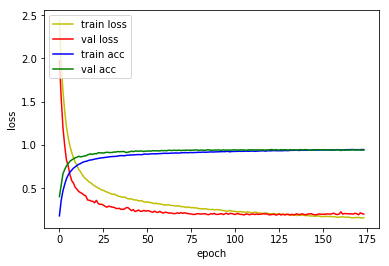

4815/4815 [==============================] - 2s 391us/sample - loss: 0.2356 - acc: 0.9290
Loss: 0.23562480327620067 Accuracy: 0.92897195

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2563 - acc: 0.2597
Epoch 00001: val_loss improved from inf to 1.49416, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_6_conv_checkpoint/001-1.4942.hdf5
36805/36805 [==============================] - 33s 909us/sample - loss: 2.2563 - acc: 0.2597 - val_loss: 1.4942 - val_acc: 0.5616
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4912 - acc: 0.5155
Epoch 00002: val_loss improved from 1.49416 to 0.97026, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_6_conv_checkpoint/002-0.9703.hdf5
36805/36805 [==============================] - 31s 840us/sample - loss: 1.4912 - acc: 0.5155 - val_loss: 0.9703 - val_acc: 0.7149
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3028 - acc: 0.9031
Epoch 00023: val_loss did not improve from 0.18794
36805/36805 [==============================] - 31s 835us/sample - loss: 0.3027 - acc: 0.9032 - val_loss: 0.2020 - val_acc: 0.9369
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2956 - acc: 0.9077
Epoch 00024: val_loss did not improve from 0.18794
36805/36805 [==============================] - 31s 837us/sample - loss: 0.2955 - acc: 0.9077 - val_loss: 0.1885 - val_acc: 0.9450
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2869 - acc: 0.9099
Epoch 00025: val_loss improved from 0.18794 to 0.17513, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_6_conv_checkpoint/025-0.1751.hdf5
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2869 - acc: 0.9099 - val_loss: 0.1751 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1839 - acc: 0.9423
Epoch 00048: val_loss did not improve from 0.13416
36805/36805 [==============================] - 31s 836us/sample - loss: 0.1840 - acc: 0.9422 - val_loss: 0.1350 - val_acc: 0.9576
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9417
Epoch 00049: val_loss improved from 0.13416 to 0.12889, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_6_conv_checkpoint/049-0.1289.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 0.1836 - acc: 0.9417 - val_loss: 0.1289 - val_acc: 0.9597
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1793 - acc: 0.9437
Epoch 00050: val_loss did not improve from 0.12889
36805/36805 [==============================] - 31s 840us/sample - loss: 0.1793 - acc: 0.9436 - val_loss: 0.1361 - val_acc: 0.9564
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9583
Epoch 00076: val_loss did not improve from 0.11537
36805/36805 [==============================] - 31s 836us/sample - loss: 0.1241 - acc: 0.9583 - val_loss: 0.1204 - val_acc: 0.9625
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1269 - acc: 0.9582
Epoch 00077: val_loss did not improve from 0.11537
36805/36805 [==============================] - 31s 835us/sample - loss: 0.1268 - acc: 0.9583 - val_loss: 0.1249 - val_acc: 0.9606
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9582
Epoch 00078: val_loss did not improve from 0.11537
36805/36805 [==============================] - 31s 837us/sample - loss: 0.1248 - acc: 0.9582 - val_loss: 0.1277 - val_acc: 0.9620
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9608
Epoch 00079: val_loss did not improve from 0.11537
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9699
Epoch 00105: val_loss did not improve from 0.11176
36805/36805 [==============================] - 31s 837us/sample - loss: 0.0912 - acc: 0.9699 - val_loss: 0.1178 - val_acc: 0.9641
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0903 - acc: 0.9696
Epoch 00106: val_loss did not improve from 0.11176
36805/36805 [==============================] - 31s 838us/sample - loss: 0.0903 - acc: 0.9696 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9691
Epoch 00107: val_loss did not improve from 0.11176
36805/36805 [==============================] - 31s 838us/sample - loss: 0.0906 - acc: 0.9691 - val_loss: 0.1169 - val_acc: 0.9655
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0880 - acc: 0.9707
Epoch 00108: val_loss did not improve from 0.11176
36805/36805 [===============

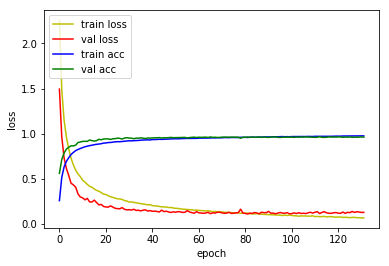

4815/4815 [==============================] - 2s 424us/sample - loss: 0.1583 - acc: 0.9516
Loss: 0.1583239990974141 Accuracy: 0.95160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0439 - acc: 0.3379
Epoch 00001: val_loss improved from inf to 1.12394, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_7_conv_checkpoint/001-1.1239.hdf5
36805/36805 [==============================] - 34s 937us/sample - loss: 2.0439 - acc: 0.3379 - val_loss: 1.1239 - val_acc: 0.6830
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1353 - acc: 0.6391
Epoch 00002: val_loss improved from 1.12394 to 0.65201, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_7_conv_checkpoint/002-0.6520.hdf5
36805/36805 [==============================] - 32s 867us/sample - loss: 1.1353 - acc: 0.6391 - val_loss: 0.6520 - val_acc: 0.8234
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1899 - acc: 0.9402
Epoch 00024: val_loss did not improve from 0.13179
36805/36805 [==============================] - 33s 888us/sample - loss: 0.1899 - acc: 0.9403 - val_loss: 0.1339 - val_acc: 0.9613
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9412
Epoch 00025: val_loss improved from 0.13179 to 0.12770, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_7_conv_checkpoint/025-0.1277.hdf5
36805/36805 [==============================] - 33s 887us/sample - loss: 0.1875 - acc: 0.9412 - val_loss: 0.1277 - val_acc: 0.9625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1801 - acc: 0.9435
Epoch 00026: val_loss improved from 0.12770 to 0.12202, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_7_conv_checkpoint/026-0.1220.hdf5
36805/36805 [==============================] - 33s 890us/sample - loss: 0.1801 - acc: 0.9435 -

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9683
Epoch 00051: val_loss did not improve from 0.10815
36805/36805 [==============================] - 32s 881us/sample - loss: 0.0949 - acc: 0.9683 - val_loss: 0.1101 - val_acc: 0.9681
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9685
Epoch 00052: val_loss did not improve from 0.10815
36805/36805 [==============================] - 33s 883us/sample - loss: 0.0928 - acc: 0.9685 - val_loss: 0.1090 - val_acc: 0.9676
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0893 - acc: 0.9712
Epoch 00053: val_loss did not improve from 0.10815
36805/36805 [==============================] - 33s 884us/sample - loss: 0.0892 - acc: 0.9712 - val_loss: 0.1166 - val_acc: 0.9679
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9709
Epoch 00054: val_loss did not improve from 0.10815
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9827
Epoch 00080: val_loss did not improve from 0.10812
36805/36805 [==============================] - 33s 891us/sample - loss: 0.0506 - acc: 0.9826 - val_loss: 0.1268 - val_acc: 0.9716
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9832
Epoch 00081: val_loss did not improve from 0.10812
36805/36805 [==============================] - 33s 886us/sample - loss: 0.0498 - acc: 0.9832 - val_loss: 0.1146 - val_acc: 0.9686
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0.9836
Epoch 00082: val_loss did not improve from 0.10812
36805/36805 [==============================] - 33s 888us/sample - loss: 0.0501 - acc: 0.9836 - val_loss: 0.1268 - val_acc: 0.9665
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9838
Epoch 00083: val_loss did not improve from 0.10812
36805/36805 [==================


1D_CNN_custom_multi_2_GMP_DO_7_conv Model


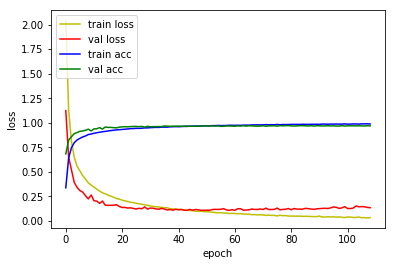

4815/4815 [==============================] - 2s 456us/sample - loss: 0.1550 - acc: 0.9541
Loss: 0.1550227659780567 Accuracy: 0.95410174

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8834 - acc: 0.3926
Epoch 00001: val_loss improved from inf to 0.91575, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_8_conv_checkpoint/001-0.9157.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.8834 - acc: 0.3926 - val_loss: 0.9157 - val_acc: 0.7049
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9510 - acc: 0.6966
Epoch 00002: val_loss improved from 0.91575 to 0.56343, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_8_conv_checkpoint/002-0.5634.hdf5
36805/36805 [==============================] - 33s 898us/sample - loss: 0.9510 - acc: 0.6966 - val_loss: 0.5634 - val_acc: 0.8355
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1469 - acc: 0.9526
Epoch 00024: val_loss improved from 0.13883 to 0.13833, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_8_conv_checkpoint/024-0.1383.hdf5
36805/36805 [==============================] - 33s 897us/sample - loss: 0.1469 - acc: 0.9526 - val_loss: 0.1383 - val_acc: 0.9571
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9554
Epoch 00025: val_loss did not improve from 0.13833
36805/36805 [==============================] - 33s 900us/sample - loss: 0.1385 - acc: 0.9554 - val_loss: 0.1404 - val_acc: 0.9560
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9560
Epoch 00026: val_loss improved from 0.13833 to 0.12808, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_8_conv_checkpoint/026-0.1281.hdf5
36805/36805 [==============================] - 33s 900us/sample - loss: 0.1344 - acc: 0.9560 -

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9835
Epoch 00053: val_loss did not improve from 0.12316
36805/36805 [==============================] - 33s 894us/sample - loss: 0.0510 - acc: 0.9835 - val_loss: 0.1426 - val_acc: 0.9620
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9830
Epoch 00054: val_loss did not improve from 0.12316
36805/36805 [==============================] - 33s 896us/sample - loss: 0.0494 - acc: 0.9830 - val_loss: 0.1478 - val_acc: 0.9627
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9850
Epoch 00055: val_loss did not improve from 0.12316
36805/36805 [==============================] - 33s 896us/sample - loss: 0.0464 - acc: 0.9850 - val_loss: 0.1604 - val_acc: 0.9611
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9836
Epoch 00056: val_loss did not improve from 0.12316
36805/36805 [=====

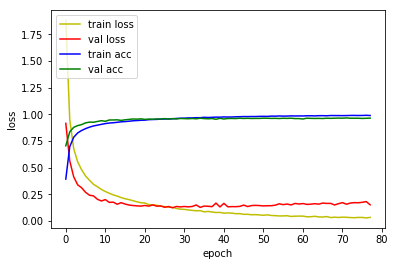

4815/4815 [==============================] - 2s 468us/sample - loss: 0.1815 - acc: 0.9429
Loss: 0.18153870397267682 Accuracy: 0.9428868



In [10]:
base = '1D_CNN_custom_multi_2_GMP_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 472us/sample - loss: 0.2356 - acc: 0.9290
Loss: 0.23562480327620067 Accuracy: 0.92897195

1D_CNN_custom_multi_2_GMP_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooling

4815/4815 [==============================] - 2s 510us/sample - loss: 0.1550 - acc: 0.9541
Loss: 0.1550227659780567 Accuracy: 0.95410174

1D_CNN_custom_multi_2_GMP_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPooling1

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 3s 529us/sample - loss: 0.2519 - acc: 0.9254
Loss: 0.25190773231837116 Accuracy: 0.9254413

1D_CNN_custom_multi_2_GMP_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooling1

4815/4815 [==============================] - 3s 551us/sample - loss: 0.1815 - acc: 0.9580
Loss: 0.18145450511492733 Accuracy: 0.95804775

1D_CNN_custom_multi_2_GMP_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPooling